In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import os
import nltk
from nltk import word_tokenize
from tqdm.auto import tqdm
import shutil

dataset_path = Path('issues.csv.gz')

# download dataset if not already present
if not dataset_path.exists():
    import requests

    with requests.get('https://vps-cd52fe2c.vps.ovh.net/nlp/issues.csv.gz', stream=True) as r:
        content_length = int(r.headers.get("Content-Length"))

        with tqdm.wrapattr(r.raw, 'read', total=content_length, desc='Downloading dataset') as raw:
            with open(dataset_path, 'wb') as f:
                shutil.copyfileobj(raw, f)

df = pd.read_csv(dataset_path, keep_default_na=False)
LANGUAGES = df['language'].unique()


In [12]:
print(LANGUAGES)
df.sample(n=10)


['Python' 'C' 'Javascript' 'Go']


,author,language,text
7384,sobolevn,Python,Here are my models: And my factories: And fina...
18983,mingrammer,Python,I want to translate it to korean. But I don't ...
89230,sebmck,Javascript,Rome contains a custom JSON parser at . The pr...
148453,andot,Go,In keymaps/dart-tools.cson: Use the tag instea...
49376,tatsuhiro-t,C,The packet number space that endpoint should s...
59258,s-u,C,What should the API be for a webpage that uses...
183043,spencerkimball,Go,We should periodically write the offset interv...
59269,s-u,C,In R 3.6.0 has been broken without documentati...
145933,lilic,Go,"Currently, kube-state-metrics uses the depreca..."
31646,berkerpeksag,Python,See for his commits so far. See also for his p...


In [15]:
df['tokenized_text'] = df['text'].apply(word_tokenize)
df.head()


,author,language,text,tokenized_text
0,llSourcell,Python,I get the following error when i attempt to tr...,"[I, get, the, following, error, when, i, attem..."
1,llSourcell,Python,won't compile. output below bash-3.2# make Mak...,"[wo, n't, compile, ., output, below, bash-3.2,..."
2,llSourcell,Python,I get this error when i attemp to build the co...,"[I, get, this, error, when, i, attemp, to, bui..."
3,llSourcell,Python,i couldn't find an instance on AWS called 'ami...,"[i, could, n't, find, an, instance, on, AWS, c..."
4,llSourcell,Python,Error below. Any ideas? dyn-160-39-195-144:wal...,"[Error, below, ., Any, ideas, ?, dyn-160-39-19..."


In [16]:
from nltk.corpus import stopwords
import nltk

nltk.download('wordnet')
sw = set(stopwords.words('english'))


def normalize_words(words: list[str]) -> list[str]:
    tokens = (
        # Make all words lowercase
        word.lower()
        for word in words
        # Remove punctuations
        if word.isalpha())
    # Remove stopwords
    tokens = [word for word in tokens if not word in sw]

    return tokens


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marcinwojnarowski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
df['normalized_text'] = df['tokenized_text'].apply(normalize_words)
df.head()

,author,language,text,tokenized_text,normalized_text
0,llSourcell,Python,I get the following error when i attempt to tr...,"[I, get, the, following, error, when, i, attem...","[get, following, error, attempt, train, networ..."
1,llSourcell,Python,won't compile. output below bash-3.2# make Mak...,"[wo, n't, compile, ., output, below, bash-3.2,...","[wo, compile, output, make, making, src, makin..."
2,llSourcell,Python,I get this error when i attemp to build the co...,"[I, get, this, error, when, i, attemp, to, bui...","[get, error, attemp, build, code, ideas]"
3,llSourcell,Python,i couldn't find an instance on AWS called 'ami...,"[i, could, n't, find, an, instance, on, AWS, c...","[could, find, instance, aws, called, link, one]"
4,llSourcell,Python,Error below. Any ideas? dyn-160-39-195-144:wal...,"[Error, below, ., Any, ideas, ?, dyn-160-39-19...","[error, ideas, jasonravel, build, failure, bui..."


## Average text length

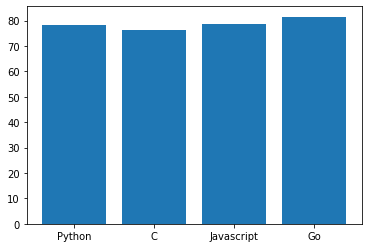

In [18]:
df['length'] = df['tokenized_text'].apply(len)

means = [np.mean(df[df['language'] == lang]['length']) for lang in LANGUAGES]

plt.bar(LANGUAGES, means)
plt.show()


## Average lexical diversity

How diverse is vocabulary of a single entry?

In [19]:
def lexical_diversity(text: list[str]) -> float:
    return len(set(text)) / len(text)


def percentage(count: float, total: float) -> float:
    return 100 * count / total


In [20]:
df['lex_div'] = df['tokenized_text'].apply(lexical_diversity)


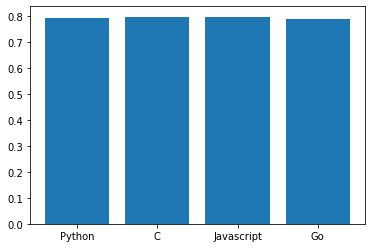

In [21]:
means = [np.mean(df[df['language'] == lang]['lex_div']) for lang in LANGUAGES]

plt.bar(LANGUAGES, means)
plt.show()


## Total lexical diversity

How all entries are similar to each other?

In [22]:
def lexical_diversity_whole(texts: pd.Series) -> float:
    words = set(
        w
        for text in texts.values
        for w in text
    )

    return len(words) / texts.apply(len).sum()


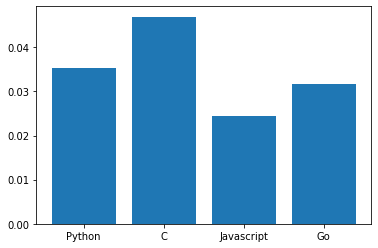

In [23]:
divs = [
    lexical_diversity_whole(df[df['language'] == lang]['tokenized_text'])
    for lang in LANGUAGES]

plt.bar(LANGUAGES, divs)
plt.show()


## Average word length

In [24]:
def average(words):
    return sum(len(word) for word in words) / len(words)


In [25]:
df['word_length'] = df['tokenized_text'].apply(average)


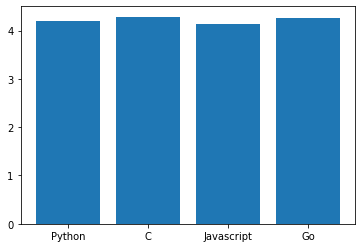

In [26]:
means = [np.mean(df[df['language'] == lang]['word_length'])
         for lang in LANGUAGES]

plt.bar(LANGUAGES, means)
plt.show()


## Percentage of words over 10 characters

In [27]:
def words_over_10(words: list[str]) -> int:
    sum = 0
    for word in words:
        if len(word) >= 10:
            sum += 1
    return sum


In [28]:
df['long_words'] = df['normalized_text'].apply(words_over_10)


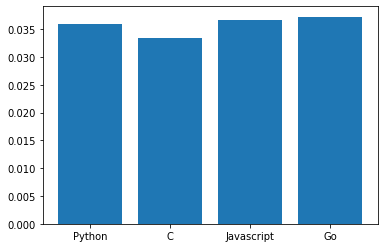

In [29]:
sums = [np.sum(df[df['language'] == lang]['long_words']) / df[df['language'] == lang]['tokenized_text'].apply(len).sum()
        for lang in LANGUAGES]

plt.bar(LANGUAGES, sums)
plt.show()


## Frequency distribution

In [30]:
from nltk import FreqDist


def get_freq_dist(tokenized_text_series: pd.Series) -> FreqDist:
    return FreqDist(w for text in tokenized_text_series.values for w in text)


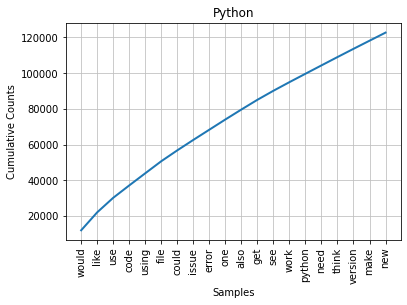

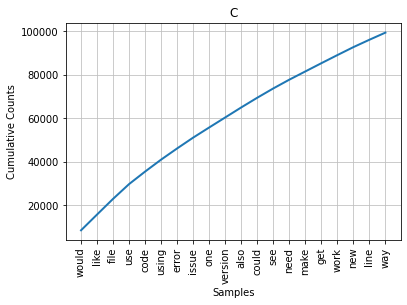

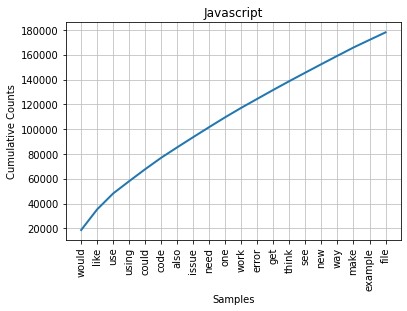

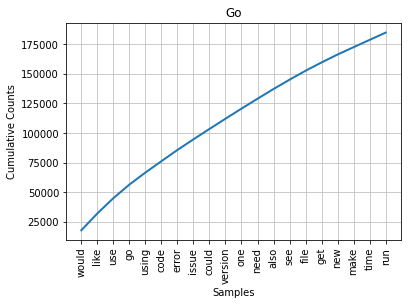

In [31]:
freq_dists = [(lang, get_freq_dist(df[df['language'] == lang]
                                   ['normalized_text'])) for lang in LANGUAGES]

for (lang, dist) in freq_dists:
    dist.plot(20, cumulative=True, title=lang)


In [32]:
total_tokens = [np.sum(df[df['language'] == lang]['length'])
                for lang in LANGUAGES]
print(total_tokens)
#Javascript, Python, C: over 40% of text is first 20 words

[3202072, 2772789, 4248497, 4831527]


# Passive sentences frequenccy
isPassive function by https://github.com/flycrane01/nltk-passive-voice-detector-for-English/blob/master/Passive-voice.py

In [33]:
beforms = ['am', 'is', 'are', 'been', 'was', 'were', 'be', 'being']  # all forms of "be"
aux = ['do', 'did', 'does', 'have', 'has', 'had']


def is_passive(words):  # NLTK tags "do" and "have" as verbs, which can be misleading in the following section
    tokens = nltk.pos_tag(words)
    tags = [i[1] for i in tokens]
    if tags.count('VBN') == 0:  # no PP, no passive voice.
        return False
    elif tags.count('VBN') == 1 and 'been' in words:  # one PP "been", still no passive voice.
        return False
    else:
        pos = [i for i in range(len(tags)) if
               tags[i] == 'VBN' and words[i] != 'been']  # gather all the PPs that are not "been".
        for end in pos:
            chunk = tags[:end]
            start = 0
            for i in range(len(chunk), 0, -1):
                last = chunk.pop()
                if last == 'NN' or last == 'PRP':
                    start = i  # get the chunk between PP and the previous NN or PRP (which in most cases are subjects)
                    break
            sentchunk = words[start:end]
            tagschunk = tags[start:end]
            verbspos = [i for i in range(len(tagschunk)) if
                        tagschunk[i].startswith('V')]  # get all the verbs in between
            if verbspos != []:  # if there are no verbs in between, it's not passive
                for i in verbspos:
                    if sentchunk[i].lower() not in beforms and sentchunk[
                        i].lower() not in aux:  # check if they are all forms of "be" or auxiliaries such as "do" or "have".
                        break
                else:
                    return True
    return False


In [34]:
def count_passives(text):
    sum = len(text)
    count = 0
    for t in text:
        if is_passive(t):
            count += 1
    return count / sum

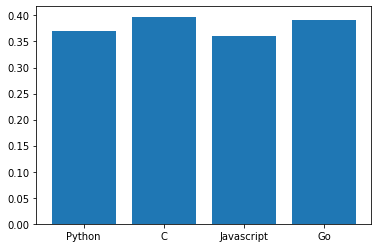

In [35]:
passive_freq = [(lang, count_passives(df[df['language'] == lang]
                                      ['tokenized_text'])) for lang in LANGUAGES]

plt.bar(*zip(*passive_freq))
plt.show()

# Flesch reading score

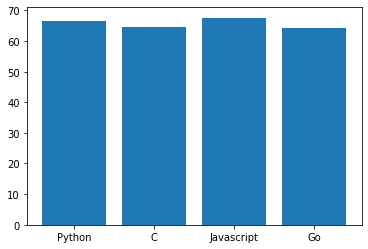

In [36]:
from textstat import textstat

df['flesch_reading_ease'] = df['text'].apply(textstat.flesch_reading_ease)

flesch_reading_score = [(lang, df[df['language'] == lang]['flesch_reading_ease'].mean()) for lang in LANGUAGES]

plt.bar(*zip(*flesch_reading_score))
plt.show()


# Flesch-Kincaid grade

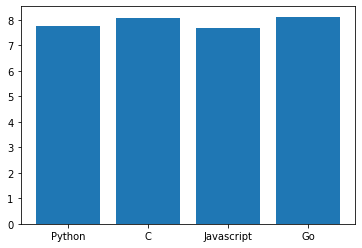

In [37]:
df['flesch_kincaid_grade'] = df['text'].apply(textstat.flesch_kincaid_grade)

flesch_kincaid_grade = [(lang, df[df['language'] == lang]['flesch_kincaid_grade'].mean()) for lang in LANGUAGES]

plt.bar(*zip(*flesch_kincaid_grade))
plt.show()
